In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import urllib.request, json
from shapely.geometry import Polygon, MultiPolygon, LineString, Point
from os.path import join
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
from os.path import join
from fiona.crs import from_epsg
from shapely.geometry import Point, LineString, Polygon, mapping
from descartes import PolygonPatch
import fiona
import osmnx as ox
import networkx as nx
import urllib.request, json

# Load Data
* parks: shapefile of all parks

In [103]:
path_parks= r'M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\RAW\Parks Events Listing\190513_download'
process_path= r'M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed'
census_path= r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Census"
iso_path= r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Isochrones\190718_Isochrones_JG"

In [105]:
parks= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\RAW\NYC_PARKS_DATA\NYCPARKS_ALLSITES.shp")

In [106]:
parks= parks.to_crs(crs='+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

In [107]:
def format_url(latlong, mode, mins):
    global url, key
    mins= ','.join([str(d) for d in mins])
    latlong= ','.join([str(p) for p in latlong])
    assert mode in ['walking', 'cycling', 'driving']
    return url.format(m=mode, p=latlong, d=mins, k=key)

In [108]:
def get_isochrone(latlong, mode, mins):
    with urllib.request.urlopen(format_url(latlong, mode, mins)) as u:
        data= json.loads(u.read().decode())
        return data

In [109]:
def prep4df(i, latlong, mode, mins):
    j= get_isochrone(latlong=latlong, mode=mode, mins=mins)
    j= j['features']
    return [[i, latlong[0], latlong[1], mode, f['properties']['contour'],
             Polygon(f['geometry']['coordinates'][0])] for f in j]
#Not really sure what the above functions do, but you wrote them so I hope that it makes sense!

## Load Park Entrances and Entrances for Study Areas
* bayst
* bushwick
* lic

In [110]:
# Load all park entrances
park_entrances= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk to a Park 2019_Reprojected.shp")

In [111]:
bayst= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_BayStreetCorridorAccessPoints.shp")

In [112]:
lic1= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_LIC_Parks1acreorlessAccessPoints.shp").set_index('gispropnum')
lic2= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_LIC_Parks20acresorgreater.shp").set_index('gispropnum')
lic3= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_LIC_Parksbtwn1and20acresAccessPoints.shp").set_index('gispropnum')

In [113]:
lic= pd.concat([lic1,lic2,lic3],axis=0,sort=True).reset_index()
lic;

In [114]:
bushwick= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_BushwickAccessPoints.shp")

In [115]:
park_entrances= park_entrances.to_crs(crs='+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

## Load the street grid
* There are two street grids: one for NYC and one for Staten Island!
    - G and S respectively
    - all steps have been duplicated for both

In [38]:
# configure the place, network type, trip times, and travel speed
place = 'New York City, New York, USA'
network_type = 'walk'
trip_times = [5, 10, 15] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [39]:
# download the street network, to configure the NYC street grid as a graph
G= ox.graph_from_place(place, network_type=network_type)
G_proj= ox.project_graph(G)

In [40]:
S= ox.graph_from_place('Staten Island, New York City, New York, USA', network_type='drive')
S_proj= ox.project_graph(S)

In [41]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute= travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G_proj.edges(data=True, keys=True):
    data['time']= data['length'] / meters_per_minute

### helpers

In [42]:
def make_iso_poly(G, center_node, trip_time=5, edge_buff=25, node_buff=25, infill=True):
    '''
    Creates isochrone polygons. Can set trip_time to 5, 10, or 15 minutes.
    G is the graph of the street network.
    center_node is the node around which to make the isochrone.
    '''
    try:
        isochrone_polys= []

        subgraph= nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points= [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf= gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf= nodes_gdf.set_index('id')

        edge_lines= []
        for n_fr, n_to in subgraph.edges():
            f= nodes_gdf.loc[n_fr].geometry
            t= nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n= nodes_gdf.buffer(node_buff).geometry
        e= gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs= list(n)+list(e)
        new_iso= gpd.GeoSeries(all_gs).unary_union

        return Polygon(new_iso.exterior)
    except KeyError:
        return 'Node error'

# Making the Isochrones

In [43]:
nodes= ox.save_load.graph_to_gdfs(G_proj, nodes=True, edges=False)

In [44]:
S_nodes= ox.save_load.graph_to_gdfs(S_proj,nodes=True,edges=False)

## Park Selection
* selparks= a selection of parks (from the parks shpaefile) that corresponds to a selection of GISPROPNUM ids
* selpark_ent= a selection of parks entrances that corresponds to the same parks as in selparks, unless the parks do not show up in the park entrances shapefile

In [132]:
selparks= parks[parks['GISPROPNUM'].isin(bayst['gispropnum'].tolist()+lic['gispropnum'].tolist())]
#example: here, I'm selecting all the parks that are in bushwick and lic

In [133]:
selparks.crs

'+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

In [139]:
selpark_ent= park_entrances[park_entrances['gispropnum'].isin(selparks['GISPROPNUM'].tolist())]
#Selecting only the entrances in the park selection

In [140]:
selpark_ent.crs

'+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

## Get the nearest nodes to the park entrances of the selected parks

In [141]:
selnodes= ox.utils.get_nearest_nodes(G_proj,selpark_ent.geometry.x.tolist(),selpark_ent.geometry.y.tolist(),method='kdtree')
#List of osmids that are closest to the park entrances

In [142]:
selnodes_S= ox.utils.get_nearest_nodes(S_proj,selpark_ent.geometry.x.tolist(),selpark_ent.geometry.y.tolist(),method='kdtree')

In [143]:
selpark_ent= selpark_ent.reset_index(drop=True)

* Dataframe of the osmid corresponding to the gispropnum of the park

In [170]:
selnode_ids= pd.DataFrame(data=np.array([selnodes,selpark_ent['gispropnum'].tolist()]).T,columns=['osmid','gispropnum'])

In [171]:
selnode_ids_S= pd.DataFrame(data=np.array([selnodes_S,selpark_ent['gispropnum'].tolist()]).T,columns=['osmid','gispropnum'])

In [172]:
selnode_ids_S= selnode_ids_S[selnode_ids_S['gispropnum'].str.slice(0,1)=='R'].copy()
# Subsetting only for staten island

In [173]:
selnode_ids['osmid']= selnode_ids['osmid'].astype('int64')
#changing the node id to an integer

In [174]:
selnode_ids_S['osmid']= selnode_ids_S['osmid'].astype('int64')
#changing the node id to an integer

In [175]:
selnode_ids= selnode_ids[selnode_ids['gispropnum'].str.slice(0,1)!='R']
selnode_ids_S= selnode_ids_S[selnode_ids_S['gispropnum'].str.slice(0,1)=='R']

In [176]:
selnodes_proj= pd.merge(nodes,selnode_ids,on='osmid',how='inner')

In [177]:
selnodes_proj_S= pd.merge(S_nodes,selnode_ids_S,on='osmid',how='inner')

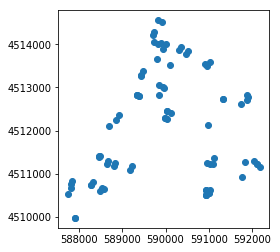

In [178]:
selnodes_proj.plot();

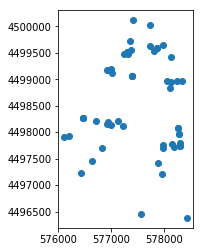

In [179]:
selnodes_proj_S.plot();

In [180]:
isonodes= selnodes_proj['osmid'].unique()
#Selected nodes to calculate walking distances

In [181]:
isonodes_S= selnodes_proj_S['osmid'].unique()

# Generate Isochrones for Nodes
* isos10: isochrones 10-minute walking distances for all nodes that aren't in Staten Island
* isos10_S: isochrones 10-minute walking distances for lal nodes that are in Staten Island

In [182]:
isos10= [make_iso_poly(G_proj, n, trip_time=10) for n in isonodes]

In [183]:
isos10_S= [make_iso_poly(S_proj, n, trip_time=10) for n in isonodes_S]

In [184]:
gdf10= gpd.GeoDataFrame(np.array([isonodes,isos10]).T,columns=['node','geometry'],crs=parks.crs)

In [185]:
gdf10_S= gpd.GeoDataFrame(np.array([isonodes_S,isos10_S]).T,columns=['node','geometry'],crs=parks.crs)

In [186]:
gdf10['walk_mins']= 10

In [189]:
gdf10_S['walk_mins']= 10

In [190]:
error_nodes= gdf10[gdf10['geometry']=='Node error']

In [191]:
error_nodes_S= gdf10_S[gdf10_S['geometry']=='Node error']

In [192]:
gdf10_2= gdf10.drop(error_nodes.index)

In [193]:
gdf10_2_S= gdf10_S.drop(error_nodes_S.index)

# Union Isochrones for Each Park

In [194]:
def park_iso(park_id, dist, gdf,df):
    '''
    Merges the different isochrones that all correspond to the same park.
    '''
    p_nodes= df[df['gispropnum']==park_id]['osmid'].values
    return gdf[(gdf['node'].isin(p_nodes))&(gdf['walk_mins']==dist)].unary_union

In [195]:
park_ids= selparks['GISPROPNUM'].values

In [196]:
park_ids_S= selparks[selparks['GISPROPNUM'].str.slice(0,1)=='R']['GISPROPNUM'].values

In [197]:
park_isos10= [park_iso(pid, 10, gdf10_2,selnodes_proj) for pid in park_ids]

In [198]:
park_gdf10= gpd.GeoDataFrame(np.array([park_ids, park_isos10]).T, columns=['node', 'geometry'], crs=parks.crs)

In [199]:
park_gdf10.shape

(50, 2)

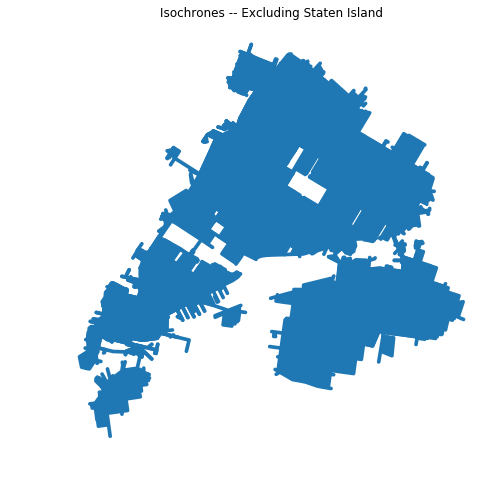

In [201]:
park_gdf10.plot(figsize=(8,8))
plt.axis('off')
plt.title('Isochrones -- Excluding Staten Island');

In [203]:
park_isos10_S= [park_iso(pid, 10 ,gdf10_2_S,selnodes_proj_S) for pid in park_ids_S]

In [204]:
park_gdf10_S= gpd.GeoDataFrame(np.array([park_ids_S, park_isos10_S]).T, columns=['node', 'geometry'], crs=parks.crs)

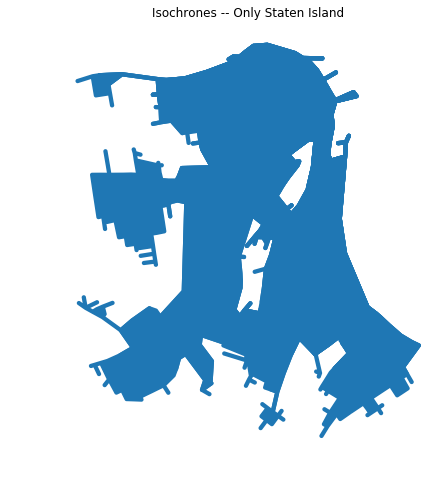

In [207]:
park_gdf10_S.plot(figsize=(8,8))
plt.axis('off')
plt.title('Isochrones -- Only Staten Island');

## Formatting for exports

In [208]:
park_gdf10_S_exp= park_gdf10_S[park_gdf10_S['geometry'].notna()].copy()

In [209]:
park_gdf10_exp= park_gdf10[park_gdf10['geometry'].notna()].copy()

In [210]:
park_gdf10_exp= park_gdf10_exp.to_crs(epsg=2263)

In [211]:
park_gdf10_S_exp= park_gdf10_S_exp.to_crs(epsg=2263)

In [212]:
park_gdf10_exp= park_gdf10_exp.rename(columns={'node':'GISPROPNUM'})

In [213]:
park_gdf10_S_exp= park_gdf10_S_exp.rename(columns={'node':'GISPROPNUM'})

In [214]:
park_gdf10_exp= pd.merge(park_gdf10_exp.copy(),selparks.drop('geometry',axis=1),on='GISPROPNUM',how='inner')

In [215]:
park_gdf10_S_exp= pd.merge(park_gdf10_S_exp.copy(),selparks.drop('geometry',axis=1),on='GISPROPNUM',how='inner')

In [216]:
park_gdf10_exp= park_gdf10_exp[~(park_gdf10_exp['GISPROPNUM'].str.slice(0,1)=='R')].copy()

In [219]:
assert park_gdf10_exp[park_gdf10_exp['GISPROPNUM'].isin(park_gdf10_S_exp['GISPROPNUM'].unique())].shape[0]==0
#Checking that there is no overlap between the isochrones in NYC excluding SI and the ischrones in SI

In [220]:
park_gdf10_exp[park_gdf10_exp['geometry'].isna()]

,GISPROPNUM,geometry,LOCATION,COMMUNITYB,COUNCILDIS,PRECINCT,ZIPCODE,BOROUGH,ACRES,ADDRESS,SIGNNAME,TYPECATEGO,WATERFRONT,NYS_ASSEMB,NYS_SENATE,US_CONGRES


## Exporting the isochrones! (change the filename each time)
* park_gdf10_exp: all park isochrones outside of Staten Island
* park_gdf10_S_exp: all park isochrones in Staten Island

In [221]:
#park_gdf10_exp.to_file(join(iso_path,'190729_NewIso10.shp'))
#Commented out so that I don't overwrite anything.

In [222]:
#park_gdf10_S_exp.to_file(join(iso_path,'190729_NewSIso10.shp'))

# Nearby Population (within the 10-minute walksheds)
__Key columns:__
* totalpop: numeric - sum of all people in the census block group from 2012-2017 ACS survey
* ShapeArea: in acres, the size of all the block groups
* ShapeArea_Walkshed: in acres, the size of the walkshed

In [272]:
#Loading all the isochrones (there were many different shapefiles and iterations of this notebook that created these files.)
parks1= gpd.read_file(join(iso_path,'190718_Iso10.shp'))
parks2= gpd.read_file(join(iso_path,'190718_Iso10StatenIsland.shp'))
parks3= gpd.read_file(join(iso_path,'190718_MajParksIso10.shp'))
parks4= gpd.read_file(join(iso_path,'190718_MajParksIso10StatenIsland.shp'))
parks5= gpd.read_file(join(iso_path,'190718_NhoodParksIso10_B006.shp'))
parks6= gpd.read_file(join(iso_path,'190718_NhoodParksIso10StatenIsland.shp'))
parks7= gpd.read_file(join(iso_path,'190718_NhoodParksIso10_Q036A_Q435.shp'))
parks8= gpd.read_file(join(iso_path,'190718_NhoodParksIso10.shp'))
parks9= gpd.read_file(join(iso_path,'190729_NewIso10.shp'))
parks10= gpd.read_file(join(iso_path,'190729_NewSIso10.shp'))

In [273]:
bg= gpd.read_file(r"S:\NYC_GIS_DATA\Census block groups 2010\NYCblockgroups2010.gdb",dtype={'GEOID10':str})

In [274]:
bg['geometry'].head()

0    (POLYGON ((-74.06043000014438 40.6063540006366...
1    (POLYGON ((-74.06613400058365 40.6140890003071...
2    (POLYGON ((-74.07920599995691 40.6434309999407...
3    (POLYGON ((-74.06368400001656 40.6022080000991...
4    (POLYGON ((-74.07972500050835 40.6289510003883...
Name: geometry, dtype: object

In [275]:
bg= bg.to_crs(epsg=2263)

In [276]:
demo= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Census\190702_totpopACS2017bg.csv",dtype={'Id2':'str'}).rename(columns={'Estimate; Total':'totalpop'})

In [277]:
bg= bg.rename(columns={'GEOID10':'Id2'})

In [278]:
demo_bg= pd.merge(bg,demo,on='Id2',how='inner')

In [279]:
demo_bg['ShapeArea']= demo_bg['geometry'].area

In [280]:
demo_bg['ShapeArea']= demo_bg['ShapeArea'].div(43560)

In [297]:
#Setting up the walksheds for ALL PARKS:
walkshed_10= pd.concat([parks1,parks2,parks3,parks4,parks5,parks6,parks7,parks8, parks9, parks10],axis=0,sort=True)

In [298]:
walkshed_10= walkshed_10[~walkshed_10['GISPROPNUM'].duplicated()]
walkshed_10.shape

(818, 16)

In [299]:
walkshed_10.crs

{'init': 'epsg:2263'}

In [300]:
parks['TYPECATEGO'];

In [301]:
#parks[~(parks['GISPROPNUM'].isin(walkshed_10['GISPROPNUM'].unique()))&(parks['TYPECATEGO'].isin(['Community Park','Neighborhood Park','Flagship Park','Playground','Jointly Operated Playground']))]['GISPROPNUM']

In [302]:
walkshed_10['ShapeArea_Walkshed']= walkshed_10['geometry'].area

In [303]:
walkshed_10['ShapeArea_Walkshed']= walkshed_10['ShapeArea_Walkshed'].div(43560)

In [304]:
walkshed_10['GISPROPNUM'].unique().shape

(818,)

In [305]:
walkshed_10[walkshed_10['geometry'].isna()]

,ACRES,ADDRESS,BOROUGH,COMMUNITYB,COUNCILDIS,GISPROPNUM,LOCATION,NYS_ASSEMB,NYS_SENATE,PRECINCT,SIGNNAME,TYPECATEGO,US_CONGRES,WATERFRONT,ZIPCODE,geometry,ShapeArea_Walkshed


In [306]:
walkshed_10.to_file(join(iso_path,'190806_allparks10minwalkshed.shp'))
#All 818 parks with their walksheds, spatial data file with geometries corresponding to the isochrones.

## Calculating area percentages
* demo_bg: all NYC block groups with demographic information
* walkshedpop: walksheds with population information, sjoin between demo_bg and walkshed_10
* bg_intersect: overlay between bgs with total population and the area of all the walksheds

In [307]:
demo_bg.crs

{'init': 'epsg:2263', 'no_defs': True}

In [308]:
walkshed_10.crs

{'init': 'epsg:2263'}

In [309]:
walkshedpop= gpd.sjoin(demo_bg,walkshed_10,op='intersects',how='inner')

In [310]:
walkshedpop['GISPROPNUM'].unique().shape

(818,)

In [311]:
bg_intersect= gpd.overlay(demo_bg,walkshed_10,how='intersection')

In [312]:
bg_intersect['GISPROPNUM'].unique().shape

(818,)

In [313]:
bg_intersect['ShapeArea_Intersect']= bg_intersect['geometry'].area.div(43560)
bg_intersect['ShapeArea_Intersect'];

In [314]:
walkshedpop['GISPROPNUM'].unique().shape

(818,)

In [315]:
bg_intersect['Pop_nearPark']= bg_intersect['totalpop']*(bg_intersect['ShapeArea_Intersect']/bg_intersect['ShapeArea'])
#Calculated by comparing the ratio of the overlay to the total area of the bg

In [316]:
walkshedpoptable= bg_intersect.groupby('GISPROPNUM').agg({'TYPECATEGO':'first','Pop_nearPark':'sum','ShapeArea_Walkshed':'first','ACRES':'first'}).rename(columns={'ACRES':'Park Acres'})

In [317]:
walkshedpoptable['PopDens']= walkshedpoptable['Pop_nearPark']/walkshedpoptable['ShapeArea_Walkshed']
#Density, population near the park divided by the total square  miles.

In [318]:
walkshedpoptable.head()
#Table to Export

,TYPECATEGO,Pop_nearPark,ShapeArea_Walkshed,Park Acres,PopDens
GISPROPNUM,,,,,
B001,Playground,10297.881979,203.212770,0.896,50.675368
B006,Triangle/Plaza,21108.864450,239.452140,0.012,88.154837
B007,Recreation Field/Courts,18229.304533,232.010714,17.500,78.570960
B008,NaN,29051.844266,363.630316,NaN,79.893900
B012,Neighborhood Park,31806.977333,323.364494,7.047,98.362615


## Exported as a table and as a shapefile with park geometries

In [266]:
#walkshedpoptable.to_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\190718_10 Min Walksheds with Population_JG\190718_10minwalksheds_pop.csv")

In [267]:
to_export= pd.merge(parks,walkshedpoptable,on='GISPROPNUM',how='inner')

In [268]:
#to_export.to_file(join(iso_path,'190719_10 Min Walksheds with Pop and Pop Density.shp'))